# <center> Earthquake Damage in Nepal </center>

## <center> In this project, a classification model to predict building damage for the one of the Nepal district has been built </center>

In [1]:
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [ ]:
%load_ext sql
%sql sqlite:////home/jovyan/nepal.sqlite

In [ ]:
%%sql
SELECT b.*, i.building_id AS b_id, d.damage_grade
FROM building_structure AS b
JOIN id_map AS i ON i.building_id = b.building_id
JOIN building_damage AS d ON i.building_id = d.building_id
WHERE district_id = 3
LIMIT 5

2. Function that will be:
- using the created previously query to create a DataFrame. 
- creating "severe_damage" column, where all buildings with a damage grade greater than `3` are encoded as 1. All other buildings are encoded as 0. 
- dropping any columns that could cause issues with leakage or multicollinearity in further modelling

In [ ]:
def wrangle(path_to_database):
    conn = sqlite3.connect(path_to_database)
    
    query = """
    SELECT DISTINCT i.building_id as b_id, b.*, d.damage_grade
    FROM id_map AS i
    JOIN building_structure AS b ON i.building_id = b.building_id
    JOIN building_damage AS d ON i.building_id = d.building_id
    WHERE district_id = 3
    """
    
    df = pd.read_sql(query, conn, index_col='b_id')
    
    df['severe_damage'] = df["damage_grade"].str[-1].astype(int)
    df['severe_damage'] = (df['severe_damage'] > 3).astype(int)
    
    df.drop(columns='damage_grade', inplace=True)
    
    drop_cols = [col for col in df.columns if "post_eq" in col]
    drop_cols.append("building_id")
    drop_cols.append("count_floors_pre_eq")
    
    df.drop(columns=drop_cols, inplace=True)
    
    return df

In [2]:
# df = wrangle("/home/jovyan/nepal.sqlite")
# df.head()

df = pd.read_excel('data.xlsx', index_col='b_id')
df.head()

,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,superstructure,severe_damage
b_id,,,,,,,,,,,,
87473,15,382,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",1
87479,12,328,7,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,"Stone, mud mortar",1
87482,23,427,20,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",1
87491,12,427,14,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",1
87496,32,360,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76533 entries, 87473 to 163998
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   age_building            76533 non-null  int64 
 1   plinth_area_sq_ft       76533 non-null  int64 
 2   height_ft_pre_eq        76533 non-null  int64 
 3   land_surface_condition  76533 non-null  object
 4   foundation_type         76533 non-null  object
 5   roof_type               76533 non-null  object
 6   ground_floor_type       76533 non-null  object
 7   other_floor_type        76533 non-null  object
 8   position                76533 non-null  object
 9   plan_configuration      76533 non-null  object
 10  superstructure          76533 non-null  object
 11  severe_damage           76533 non-null  int64 
dtypes: int64(4), object(8)
memory usage: 7.6+ MB


3. Checking balance of the class

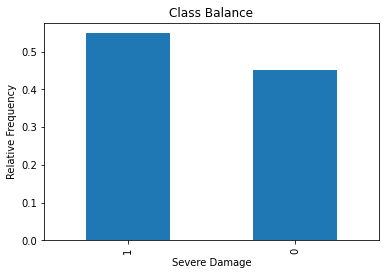

In [4]:
df['severe_damage'].value_counts(normalize=True).plot(kind='bar')
plt.xlabel("Severe Damage")
plt.ylabel("Relative Frequency")
plt.title("Class Balance");

4. Checking the relationship between the footprint size of a building and the damage it sustained in the earthquake.  Boxplot that shows the distributions of the `"plinth_area_sq_ft"` column for both groups in the `"severe_damage"` column.

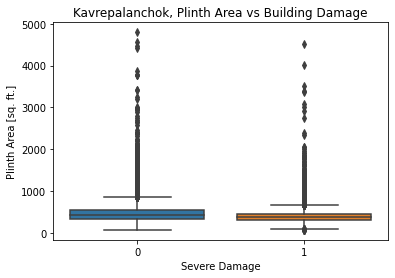

In [5]:
sns.boxplot(x="severe_damage", y="plinth_area_sq_ft", data=df)
plt.xlabel("Severe Damage")
plt.ylabel("Plinth Area [sq. ft.]")
plt.title("Kavrepalanchok, Plinth Area vs Building Damage");

5. Checking if buildings with certain roof types are more likely to suffer severe damage.

In [6]:
roof_pivot = df.pivot_table(values="severe_damage", index="roof_type", aggfunc='mean')
roof_pivot

,severe_damage
roof_type,
Bamboo/Timber-Heavy roof,0.569477
Bamboo/Timber-Light roof,0.604842
RCC/RB/RBC,0.040715


6. Creating feature matrix and target vector "severe damage"

In [7]:
target = "severe_damage"
X = df.drop(columns=target)
y = df["severe_damage"]
print("Feature matrix shape:", X.shape)
print("Target vector shape:", y.shape)

Feature matrix shape: (76533, 11)
Target vector shape: (76533,)


7. Splitting data into train and validation sets

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

X_train shape: (61226, 11)
y_train shape: (61226,)
X_val shape: (15307, 11)
y_val shape: (15307,)


# Building models

Calculating the baseline accuracy score for your model.

In [10]:
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 2))

Baseline Accuracy: 0.55


## LogisticRegression model

In [11]:
from category_encoders import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.pipeline import Pipeline, make_pipeline

In [12]:
model_lr = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    LogisticRegression(max_iter=10000)
)
model_lr.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['land_surface_condition',
                                     'foundation_type', 'roof_type',
                                     'ground_floor_type', 'other_floor_type',
                                     'position', 'plan_configuration',
                                     'superstructure'],
                               use_cat_names=True)),
                ('logisticregression', LogisticRegression(max_iter=10000))])

In [13]:
lr_train_acc = model_lr.score(X_train, y_train)
lr_val_acc = model_lr.score(X_val, y_val)

print("Logistic Regression, Training Accuracy Score:", lr_train_acc)
print("Logistic Regression, Validation Accuracy Score:", lr_val_acc)

Logistic Regression, Training Accuracy Score: 0.6512592689380329
Logistic Regression, Validation Accuracy Score: 0.6529039001763899


In [14]:
f1_score_train = f1_score(y_train, model_lr.predict(X_train))
f1_score_val = f1_score(y_val, model_lr.predict(X_val))

print("Logistic Regression, Training F1 Score:", f1_score_train)
print("Logistic Regression, Validation F1 Score:", f1_score_val)

Logistic Regression, Training F1 Score: 0.7463108618682128
Logistic Regression, Validation F1 Score: 0.7481871178728849


## Decision Tree model

In [15]:
from sklearn.tree import DecisionTreeClassifier
from category_encoders import OrdinalEncoder

In [16]:
depth_hyperparams = range(1, 16)
training_acc = []
validation_acc = []
training_f1_score = []
validation_f1_score = []
for d in depth_hyperparams:
    model_dt = make_pipeline(
        OrdinalEncoder(),
        DecisionTreeClassifier(max_depth=d)
    )
    model_dt.fit(X_train, y_train)
    training_acc.append(model_dt.score(X_train, y_train))
    validation_acc.append(model_dt.score(X_val, y_val))
    training_f1_score.append(f1_score(y_train, model_dt.predict(X_train)))
    validation_f1_score.append(f1_score(y_val, model_dt.predict(X_val)))

In [17]:
pd.DataFrame({'Training Accuracy Scores': training_acc,
              'Validation Accuracy Scores': validation_acc,
              'Training F1 Scores': training_f1_score, 
              'Validation F1 Scores': validation_f1_score
             })

,Training Accuracy Scores,Validation Accuracy Scores,Training F1 Scores,Validation F1 Scores
0,0.630304,0.635004,0.746401,0.750525
1,0.630304,0.635004,0.746401,0.750525
2,0.642292,0.645391,0.751139,0.754033
3,0.653530,0.652773,0.746544,0.747422
4,0.654395,0.652904,0.748568,0.748830
5,0.657662,0.658457,0.751959,0.753698
6,0.662594,0.658588,0.749040,0.747047
7,0.666482,0.662703,0.748373,0.746053
8,0.673946,0.664467,0.743469,0.736696
9,0.680544,0.665643,0.747753,0.736484


Plotting the validation curve

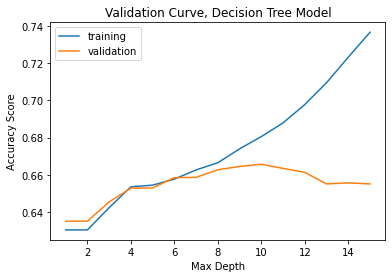

In [18]:
plt.plot(depth_hyperparams, training_acc, label='training')
plt.plot(depth_hyperparams, validation_acc, label='validation')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy Score')
plt.title("Validation Curve, Decision Tree Model")
plt.legend();

Using model with best parameters

In [19]:
final_model_dt = make_pipeline(
    OrdinalEncoder(),
    DecisionTreeClassifier(max_depth=6)
)
final_model_dt.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['land_surface_condition',
                                      'foundation_type', 'roof_type',
                                      'ground_floor_type', 'other_floor_type',
                                      'position', 'plan_configuration',
                                      'superstructure'],
                                mapping=[{'col': 'land_surface_condition',
                                          'data_type': dtype('O'),
                                          'mapping': Flat              1
Moderate slope    2
Steep slope       3
NaN              -2
dtype: int64},
                                         {'col': 'foundation_type',
                                          'dat...
E-shape                             7
Others                              8
Building with Central Courtyard     9
H-shape                            10
NaN                                -2
dtype: int64},
          

### Importing test data 

In [20]:
X_test = pd.read_excel("test_data.xlsx", index_col="b_id")
y_test_pred = final_model_dt.predict(X_test)
y_test_pred[-10:]

array([1, 1, 1, 1, 1, 1, 0, 0, 0, 1], dtype=int64)

Checking most important features

In [21]:
features = X_train.columns
importances = final_model_dt.named_steps["decisiontreeclassifier"].feature_importances_

print("Features:", features[:3])
print("Importances:", importances[:3])

feat_imp = pd.Series(importances, index=features).sort_values()
feat_imp

Features: Index(['age_building', 'plinth_area_sq_ft', 'height_ft_pre_eq'], dtype='object')
Importances: [0.10444234 0.02056113 0.10799554]


position                  0.000230
plan_configuration        0.000230
land_surface_condition    0.000844
foundation_type           0.007626
ground_floor_type         0.008637
other_floor_type          0.011584
plinth_area_sq_ft         0.020561
superstructure            0.069642
age_building              0.104442
height_ft_pre_eq          0.107996
roof_type                 0.668208
dtype: float64

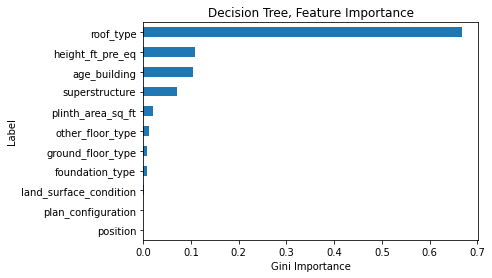

In [22]:
feat_imp.plot(kind='barh')
plt.xlabel("Gini Importance")
plt.ylabel("Label")
plt.title("Decision Tree, Feature Importance");